In [1]:
from environment import Qsim
from environment.Qenv_unitary import Qenv_unitary_gym
from time import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch as pt
import gymnasium as gym
from typing import Dict

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import HerReplayBuffer
from stable_baselines3.common.evaluation import evaluate_policy
import os
import pandas as pd

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_results(file_path, window=1000):
    df = pd.read_csv(file_path, skiprows=1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    axs[0].plot(df['is_success'].rolling(window=window).mean())
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Solved episodes (%)')
    #axs[0].set_xscale('log');

    axs[1].plot(df['Fidelity'].rolling(window=window).mean())
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Average gate Fidelity')
    #axs[1].set_xscale('log');

    axs[2].plot(df['l'].rolling(window=window).mean())
    axs[2].set_xlabel('Episodes')
    axs[2].set_ylabel('Lenght sequence')
    #axs[2].set_xscale('log');

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict):
        # We do not know features-dim here before going over all the items,
        # so put something dummy for now. PyTorch requires calling
        # nn.Module.__init__ before adding modules
        super().__init__(observation_space, features_dim=1)

        extractors: Dict[str, pt.nn.Module] = {}

        extractors['observation'] = pt.nn.Flatten()
        self.extractors = pt.nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = observation_space['observation'].shape[0]

    def forward(self, observations) -> pt.Tensor:

        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            encoded_tensor = extractor(observations[key])
        # Return a (B, self._features_dim) PyTorch tensor, where B is batch dimension.
        return encoded_tensor

In [3]:
from scipy.stats import unitary_group

N = 1
hadamard = 1.0/pt.sqrt(pt.tensor(2)) * pt.tensor([[1,1],[1,-1]], dtype=pt.complex64, device='cuda:0')
haar_matrix = pt.tensor(unitary_group.rvs(dim=2**N, size=1), dtype=pt.complex64, device='cuda:0')

target = haar_matrix
max_steps = 130
num_episodes = int(1e4)
train_steps = num_episodes * max_steps
algo = 'PPO'
obs_type = 'Dict' if algo == 'DQN' else 'Box'

In [4]:
env = Qenv_unitary_gym(N=N, target=target, max_steps=max_steps, obs_type=obs_type, fidelity_function='Haar_integral', fidelity_threshold=0.99)

# Create log dir
log_dir = "logs/"
train_log_dir = log_dir + "train_logs/"
evals_log_dir = log_dir + "evals_logs/"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(evals_log_dir, exist_ok=True)
# Logs will be saved in log_dir/monitor.csv
logs_env = Monitor(env, filename=train_log_dir, info_keywords=("is_success", "Fidelity"))

In [8]:
# Initialize the model
if algo == 'DQN':
    model = DQN("MultiInputPolicy", logs_env, replay_buffer_class=HerReplayBuffer,
                # Parameters for HER
                replay_buffer_kwargs=dict(
                    n_sampled_goal=4,
                    goal_selection_strategy="future"),
                # Parameters for Neural network
                policy_kwargs=dict(net_arch=[128, 128],
                                activation_fn = pt.nn.SELU,
                                features_extractor_class = CustomCombinedExtractor),
                # Rest of Parameters
                buffer_size=int(5e5),
                learning_rate=1e-4,
                gamma=0.99931,
                batch_size=200,
                train_freq=(1,"episode"),
                verbose=1, 
                device="cuda")
elif algo == 'PPO':
    model = PPO("MlpPolicy", logs_env,
                # Parameters for Neural network
                policy_kwargs=dict(net_arch=[128, 128],
                                activation_fn = pt.nn.SELU),
                # Rest of Parameters
                learning_rate=1e-4,
                gamma=0.99931,
                batch_size=200,
                verbose=1, 
                device="cuda")

#print(model.policy)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [9]:
rewards, eps_lenght = evaluate_policy(model, env, n_eval_episodes=100, deterministic=False, return_episode_rewards=True)

condition = lambda x: int(x)>-max_steps
solved = any(condition(reward) for reward in rewards)
print('Is there any solved episode? ', solved)
if solved == True:
    num_solutions = sum(1 for reward in rewards if condition(reward))
    print('Solved episodes: ', num_solutions)

Is there any solved episode?  True
Solved episodes:  10


In [11]:
from stable_baselines3.common.callbacks import CallbackList, EvalCallback, StopTrainingOnMaxEpisodes

log_interval = 100

eval_callback = EvalCallback(env, best_model_save_path=evals_log_dir,n_eval_episodes=1,
                             log_path=evals_log_dir, eval_freq=log_interval*max_steps,
                             deterministic=True, render=False, verbose=0)
max_episodes_callback = StopTrainingOnMaxEpisodes(max_episodes=num_episodes, verbose=1)

callback = CallbackList([max_episodes_callback, eval_callback])

# Train model
model.learn(total_timesteps=train_steps, log_interval=log_interval, callback=callback);

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 130           |
|    mean_reward          | -130          |
|    success_rate         | 0             |
| time/                   |               |
|    total_timesteps      | 13000         |
| train/                  |               |
|    approx_kl            | 0.00011727114 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.09         |
|    explained_variance   | -0.0145       |
|    learning_rate        | 0.0001        |
|    loss                 | 76.7          |
|    n_updates            | 60            |
|    policy_gradient_loss | -0.000262     |
|    value_loss           | 217           |
-------------------------------------------
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 130           |
|    mean_reward          | -130

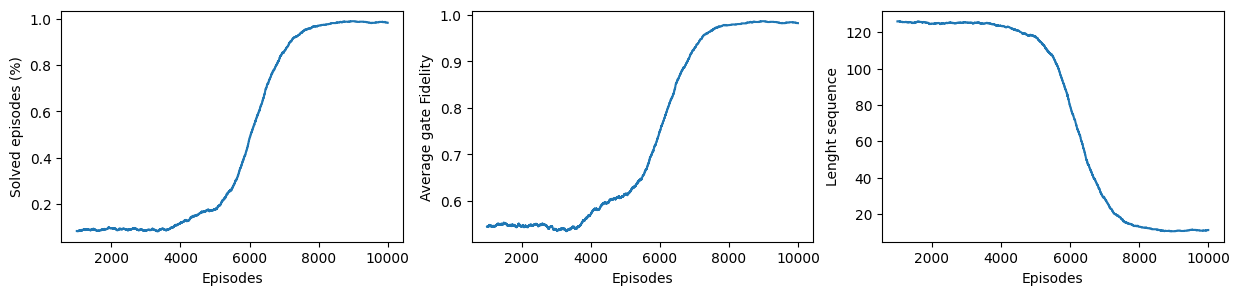

In [12]:
file = train_log_dir + "monitor.csv"
plot_results(file)

In [14]:
best_model = PPO.load(evals_log_dir + "best_model")
mean_reward, std_reward = evaluate_policy(best_model, env=env, n_eval_episodes=1, deterministic=True)

In [25]:
obs, _ = env.reset()
finish = False
score = 0
while finish == False:
    action = best_model.predict(obs, deterministic=True)
    obs_, reward, done, trunc, info = env.step(action[0].item())
    score += reward
    finish = done or trunc
    obs = obs_

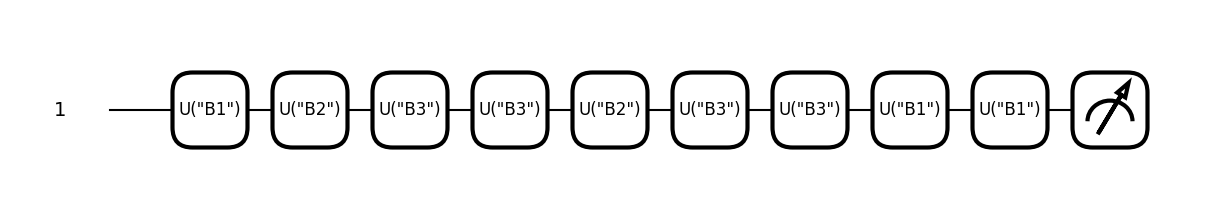

In [27]:
env.draw_circuit()